In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import pickle

from scipy.optimize import fsolve
from scipy.optimize import differential_evolution
from scipy.interpolate import UnivariateSpline
from scipy.optimize import curve_fit

from PySpice.Spice.Netlist import Circuit
import PySpice.Logging.Logging as Logging
from PySpice.Unit import *

from CC4_PreAmplifier import *
from signals import *

from tqdm.notebook import tqdm

import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import seaborn as sns


sns.set_theme(style = 'white')
mpl.rc('xtick.minor', visible = True)
mpl.rc('ytick.minor', visible = True)
mpl.rc('xtick', direction='in', top=True, bottom = True)
mpl.rc('ytick', direction='in', right=True, left = True)

In [2]:
T_operating = 89

# cascode params
V_DD = 11.7     # Supply voltage [V]
R_L = 1.6e3     # Load resistor  [Ohm]
V_G2 = 4.5      # Bias voltage for Q2's gate [V]

# feedback params
R_f = 1e9
C_f = 400e-15

ADC_to_V = 0.13/(20e3)
V_to_ADC = 1/ADC_to_V
print('ADC to V:',round(ADC_to_V,7))

ADC to V: 6.5e-06


# Cascode Stage

In [3]:
MX11_data_sheet = {
    'I_DSS':30e-3, 
    'VTO':-4.2, 
    'g_m':5.6e-3, 
    'nominal_T':293.15
    }

BF862_data_sheet = {
    'I_DSS':17e-3, 
    'VTO':-0.8, 
    'g_m':45e-3, 
    'nominal_T':298.15
    }



MX11_params = infer_jfet_params(I_DSS=MX11_data_sheet['I_DSS'],
                                VTO=MX11_data_sheet['VTO'],
                                g_m=MX11_data_sheet['g_m'],
                                T=MX11_data_sheet['nominal_T'],
                                method='differential_evolution'
                                )

BF862_params = infer_jfet_params(I_DSS=BF862_data_sheet['I_DSS'],
                                VTO=BF862_data_sheet['VTO'],
                                g_m=BF862_data_sheet['g_m'],
                                T=BF862_data_sheet['nominal_T'],
                                method='differential_evolution'
                                )

jfet1 = JFET(W_L_ratio=MX11_params['W_L_ratio'],
                a=MX11_params['a'],
                N_d=MX11_params['N_d'])

jfet2 = JFET(W_L_ratio=BF862_params['W_L_ratio'],
                a=BF862_params['a'],
                N_d=BF862_params['N_d'])


mx11_ds_T = MX11_data_sheet['nominal_T']
bf862_ds_T = BF862_data_sheet['nominal_T']

mx11_ds_idss = MX11_data_sheet['I_DSS']
bf862_ds_idss = BF862_data_sheet['I_DSS']

mx11_ds_gm = MX11_data_sheet['g_m']
bf862_ds_gm = BF862_data_sheet['g_m']

I_dds_mx11 = jfet1.I_d(V_ds=10., V_gs=0., T=MX11_data_sheet['nominal_T'])
I_dds_bf862 = jfet2.I_d(V_ds=10., V_gs=0., T=BF862_data_sheet['nominal_T'])

g_m_mx11_computed = np.abs(jfet1.I_d(10.,0.,mx11_ds_T)/jfet1.pinch_off_voltage())
g_m_bf862_computed = np.abs(2*jfet2.I_d(10.,0.,bf862_ds_T)/jfet2.pinch_off_voltage())

print('--------------------------------------------')
print(f'* MX11 I_DSS @ {mx11_ds_T} K: \nnominal: {mx11_ds_idss} \ncomputed: {I_dds_mx11} \ndifference: {np.abs(mx11_ds_idss-I_dds_mx11)}\n')
#print(f'* MX11 trasconductance @ {mx11_ds_T} K:  \nnominal: {mx11_ds_gm} \ncomputed: {g_m_mx11_computed} \ndifference: {np.abs(mx11_ds_gm-g_m_mx11_computed)}')
print('--------------------------------------------')
print(f'* BF862 I_DSS @ {bf862_ds_T} K: \nnominal: {bf862_ds_idss} \ncomputed: {I_dds_bf862} \ndifference: {np.abs(bf862_ds_idss-I_dds_bf862)}\n')
#print(f'* BF862 trasconductance @ {bf862_ds_T} K:  \nnominal: {bf862_ds_gm} \ncomputed: {g_m_bf862_computed} \ndifference: {np.abs(bf862_ds_gm-g_m_bf862_computed)}')
print('--------------------------------------------')

--------------------------------------------
* MX11 I_DSS @ 293.15 K: 
nominal: 0.03 
computed: 0.02547049519666621 
difference: 0.0045295048033337885

--------------------------------------------
* BF862 I_DSS @ 298.15 K: 
nominal: 0.017 
computed: 0.017139882200205358 
difference: 0.00013988220020535666

--------------------------------------------


## Explore ic in order to compute the Cascode Transfer function

In [4]:
def cascode_operating_point_exploration(V_in, V_DD, R_L, V_G2, T, jfet1, jfet2):
    
    # Define the objective function as the sum of squared residuals:
    def objective(vars):
        V_x, V_out = vars
        # Q1: common-source, gate = V_in, source = 0, drain = V_x
        I1 = jfet1.I_d(V_ds=V_x, V_gs=V_in, T=T)
        # Q2: common-gate, gate = V_G2, source = V_x, drain = V_out => V_ds = V_out - V_x
        I2 = jfet2.I_d(V_ds=V_out - V_x, V_gs=V_G2 - V_x, T=T)
        eq1 = I1 - I2
        eq2 = V_out - (V_DD - R_L * I2)
        return eq1**2 + eq2**2
    

    bounds = [(0, V_G2), (0, V_DD)]
    
    # Use differential evolution to find the minimum of the objective function:
    result = differential_evolution(objective, bounds)
    V_x_sol, V_out_sol = result.x
    
    # Compute the output current (assuming both transistors share the same current)
    I_sol = jfet1.I_d(V_ds=V_x_sol, V_gs=V_in, T=T)
    return V_x_sol, V_out_sol, I_sol

#-----------------------------------------------------------------------------------------------------------

V_in_range_exploration = np.linspace(-5, 5, 1000) 
V_out_range_exploration= np.zeros_like(V_in_range_exploration)


# Compute the static transfer curve: for each V_in, determine V_out.
for i, V_in in enumerate(tqdm(V_in_range_exploration, desc="Sweeping V_in")):
    V_x, V_out, i_out = cascode_operating_point_exploration(V_in, V_DD, R_L, V_G2, T_operating, jfet1, jfet2)
    V_out_range_exploration[i] = V_out

Sweeping V_in:   0%|          | 0/1000 [00:00<?, ?it/s]

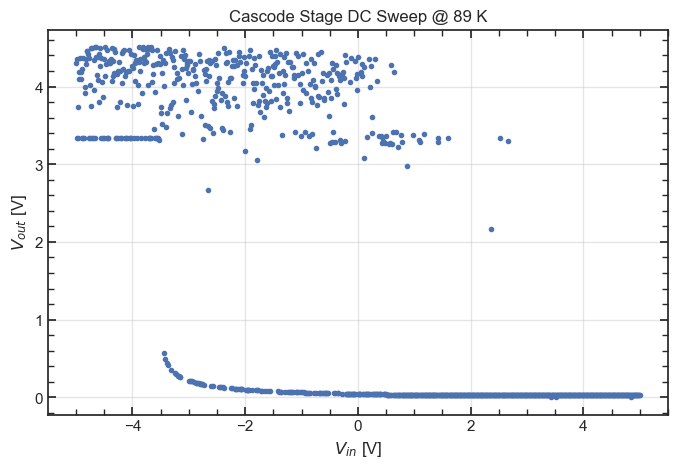

In [5]:
plt.figure(figsize=(8, 5))
plt.title('Cascode Stage DC Sweep @ 89 K')
plt.scatter(V_in_range_exploration, V_out_range_exploration, marker='.')
plt.xlabel('$V_{in}$ [V]')
plt.ylabel('$V_{out}$ [V]')
plt.grid(alpha=0.5)
plt.show()

## Fix ic and compute the Transfer Function

In [6]:
def cascode_operating_point(V_in, V_DD, R_L, V_G2, T, jfet1, jfet2):
    """
    For a given input voltage V_in and temperature T, solve for the node voltage V_x 
    (the connection between Q1 drain and Q2 source) and the output voltage V_out.
    """
    # Initial guesses for V_x and V_out   
    V_x0 = 0.0001
    V_out0 = 0.0001
    
    def equations(vars):
        V_x, V_out = vars
        # Q1: common-source, gate = V_in, source = 0, drain = V_x
        I1 = jfet1.I_d(V_ds=V_x, V_gs=V_in, T=T)
        # Q2: common-gate, gate = V_G2, source = V_x, drain = V_out => V_ds = V_out - V_x
        I2 = jfet2.I_d(V_ds=V_out - V_x, V_gs=V_G2 - V_x, T=T)
        eq1 = I1 - I2
        eq2 = V_out - (V_DD - R_L * I2)
        return [eq1, eq2]
    
    solution = fsolve(equations, [V_x0, V_out0])
    V_x_sol, V_out_sol = solution
    I_sol = jfet1.I_d(V_ds=V_x_sol, V_gs=V_in, T=T)
    return V_x_sol, V_out_sol, I_sol

#--------------------------------------------------------------------------------------------------------------------------


V_in_range = np.linspace(-5, 5, 100000) # steps of 0.1 mV
V_out_sweep = np.zeros_like(V_in_range)
V_x_range = np.zeros_like(V_in_range)
I_out = np.zeros_like(V_in_range) 


# Compute the static transfer curve
for i, V_in in enumerate(tqdm(V_in_range, desc="Sweeping V_in")):
    V_x, V_out, i_out = cascode_operating_point(V_in, V_DD, R_L, V_G2, T_operating, jfet1, jfet2)
    V_out_sweep[i] = V_out
    V_x_range[i] = V_x
    I_out[i] = i_out

Sweeping V_in:   0%|          | 0/100000 [00:00<?, ?it/s]

/Users/raffaelegaudio/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


KeyboardInterrupt: 

In [ ]:
cascode_transfer_function = UnivariateSpline(V_in_range,V_out_sweep ,s=0)
small_signal_cascode_gain = cascode_transfer_function.derivative()

V_out_cascode = cascode_transfer_function(V_in_range)
cascode_gain = small_signal_cascode_gain(V_in_range)


df = pd.DataFrame({'V_bias': V_in_range, 'gain': cascode_gain})
print('\nMax gain:\n',df.loc[df['gain']==df['gain'].min(),:])


plt.rcParams.update({
    'font.size': 14,          # Default text size
    'axes.titlesize': 16,     # Title size
    'axes.labelsize': 14,     # Axis label size
    'xtick.labelsize': 12,    # X-tick label size
    'ytick.labelsize': 12,    # Y-tick label size
    'legend.fontsize': 13     # Legend size
})


# Plot the transfer function:
plt.figure(figsize=(8, 5))
plt.title('Cascode Stage IO @ 89 K', fontsize=16)
plt.plot(V_in_range, V_out_cascode, color='firebrick', ls='dashed', label ='Interpolation')
plt.scatter(V_in_range,V_out_sweep, marker='.', alpha=0.5, label='DC Sweep Data')
plt.xlabel('$V_{in}$ [V]')
plt.ylabel('$V_{out}$ [V]')
plt.legend(frameon=False)
plt.show()

# Op Amps Stage

In [ ]:
# ----------------------------------------
# Create a netlist for the op-amps stages 
# ----------------------------------------
circuit = Circuit('OpAmp_Transfer_Function')
circuit.include('LMH6654.LIB')  

# --- Power supplies and bias for the first op-amp stage (Integrator) ---
vcc  = 9.1 
vee  = -3.2 
vb1_p = 4.5 

circuit.V('vcc', 'vcc', circuit.gnd, vcc)
circuit.V('vee', 'vee', circuit.gnd, vee)
circuit.V('+vb1', '+vb1', circuit.gnd, vb1_p)

circuit.R('r5', '+vb1', 'node_r5c1', 4.3e3)
circuit.C('c1', 'node_r5c1', circuit.gnd, 4.7e-6)
circuit.R('r8', 'vcc', 'vcc_filtered', 22)
circuit.C('c3', 'vcc_filtered', circuit.gnd, 2.2e-6)
circuit.R('r7', 'vee', 'vee_filtered', 22)
circuit.C('c2', 'vee_filtered', circuit.gnd, 2.2e-6)

# --- Use a DC voltage source for input that we can sweep ----------------
# This source will represent the cascode output driving the op-amp stage.
circuit.V('vin', 'sig_in', circuit.gnd, 0)  

# Input resistor from signal to op-amp stage:
circuit.R('r6', 'sig_in', 'u1_inv_in', 22)

# Integrator feedback network for the first stage:
circuit.C('c4', 'u1_inv_in', 'u1_out', 10e-12)
circuit.R('r10', 'u1_out', circuit.gnd, 47)

# --- First op-amp (U1) ---------------------------------------------------
circuit.X('u1', 'LMH6654',
            'u1_inv_in',      # -IN (pin 2)
            'node_r5c1',      # +IN (pin 3)
            'vcc_filtered',   # VCC (pin 8)
            'vee_filtered',   # VEE (pin 4)
            'u1_out')         # OUT (pin 1)

# --- Second Stage (Inverter) ---------------------------------------------
vcc2 = 4.5 
vee2 = -9.1 
vb1_n = -0.9 

circuit.V('vcc2', 'vcc2', circuit.gnd, vcc2)
circuit.V('vee2', 'vee2', circuit.gnd, vee2)
circuit.V('-vb1', '-vb1', circuit.gnd, vb1_n)

circuit.R('r12', '-vb1', 'node_r12c7', 4.3e3)
circuit.C('c7', 'node_r12c7', circuit.gnd, 4.7e-6)
circuit.R('r15', 'vcc2', 'vcc2_filtered', 22)
circuit.C('c9', 'vcc2_filtered', circuit.gnd, 2.2e-6)
circuit.R('r14', 'vee2', 'vee2_filtered', 22)
circuit.C('c8', 'vee2_filtered', circuit.gnd, 2.2e-6)

# Gain network for the inverter stage:
circuit.R('r13', 'u1_out', 'u2_inv_in', 910)
circuit.R('r16', 'u2_inv_in', 'out_n', 910)
circuit.R('r17', 'out_n', circuit.gnd, 47)

# Second op-amp (U2) used as an inverter:
circuit.X('u2', 'LMH6654',
            'u2_inv_in',      # -IN (pin 2)
            'node_r12c7',     # +IN (pin 3)
            'vcc2_filtered',  # VCC (pin 8)
            'vee2_filtered',  # VEE (pin 4)
            'out_n')          # OUT (pin 1)

# --------------------------------------------------------------------------
# DC sweep analysis.
simulator = circuit.simulator(simulator='ngspice-subprocess',
                            temperature=T_operating-273.15, 
                            nominal_temperature=25)
analysis = simulator.dc(Vvin=slice(-5, 5, 0.0001))  

# Extract sweep data:
Vin_data = np.array(analysis.sweep)
Vout_data = np.array(analysis.out_n.as_ndarray())

In [ ]:
opamps_transfer_function = UnivariateSpline(Vin_data,Vout_data,s=0)
small_signal_opamp_gain = opamps_transfer_function.derivative()

V_out_opamps = opamps_transfer_function(Vin_data)
opamp_gain = small_signal_opamp_gain(Vin_data)

plt.rcParams.update({
    'font.size': 14,          # Default text size
    'axes.titlesize': 16,     # Title size
    'axes.labelsize': 14,     # Axis label size
    'xtick.labelsize': 12,    # X-tick label size
    'ytick.labelsize': 12,    # Y-tick label size
    'legend.fontsize': 13     # Legend size
})


plt.figure(figsize=(8, 5))
plt.title('Op-Amps Stage IO @ 89 K', fontsize=16)
plt.scatter(Vin_data, Vout_data, marker='.', alpha=0.6, label='DC Sweep Data')
plt.plot(Vin_data,V_out_opamps, color='firebrick',ls='--', label='Interpolation')
plt.xlabel('$V_{in}$ [V]')
plt.ylabel('$V_{out}$ [V]')
plt.legend(frameon=False)
plt.show()


# Full CSA Transfer Function

In [ ]:
V_in_total_sweep = np.linspace(-5, 5, 100000) 

V_cascode = cascode_transfer_function(V_in_total_sweep)
V_opamps = opamps_transfer_function(V_cascode)

total_transfer_function = UnivariateSpline(V_in_total_sweep,V_opamps, s=0)
small_signal_final_gain = total_transfer_function.derivative()

final_out = total_transfer_function(V_in_total_sweep)
total_gain_1 = small_signal_final_gain(V_in_total_sweep)
total_gain_2 =  small_signal_opamp_gain(V_x)*V_cascode*small_signal_cascode_gain(V_in_total_sweep)


# Plot the transfer function:
plt.figure(figsize=(8,5))
plt.plot(V_in_total_sweep, final_out, label='Curve Fit')
#plt.plot(V_in_total_sweep,V_opamps,label='DC Sweep Data')
plt.xlabel('$V_{in}$ [V]')
plt.ylabel('$V_{out}$ [V]')
plt.title('Full CSA IO @ 89 K', fontsize=16)
#plt.grid(alpha=0.5)
#plt.legend()
plt.show()